# Курсовой проект: [Real Estate Price Prediction](https://www.kaggle.com/competitions/real-estate-price-prediction-moscow)

## 1. Подключение библиотек и скриптов

#### Импорты

In [1]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score as r2

#### Общие настройки

In [2]:
plt.style.use('fivethirtyeight') 
plt.rc('font', size=8)

#### Константы проекта

In [3]:
RANDOM_STATE = 256
DATA_PATH = Path('../data/real-estate-price-prediction-moscow/')

## 2. Загрузка данных

#### Dataset Description

**File descriptions:**
 - train.csv - the training set
 - test.csv - the test set
 - sampleSubmission.csv - a sample submission file in the correct format

**Data fields:**
 - Id - идентификационный номер квартиры
 - DistrictId - идентификационный номер района
 - Rooms - количество комнат
 - Square - площадь
 - LifeSquare - жилая площадь
 - KitchenSquare - площадь кухни
 - Floor - этаж
 - HouseFloor - количество этажей в доме
 - HouseYear - год постройки дома
 - Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
 - Social_1, Social_2, Social_3 - социальные показатели местности
 - Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
 - Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
 - Price - цена квартиры

In [4]:
data = pd.read_csv(DATA_PATH / 'train.csv')
cols = data.columns

X = data[cols[cols != 'Price']]
y = data['Price']

X.sample(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
335,10053,121,2.0,55.212572,32.294431,11.0,7,16.0,1984,0.212515,B,B,19,3293,16,628.0,3,7,B
3506,3977,23,2.0,55.183073,53.561087,1.0,4,3.0,1977,0.005767,B,B,1,388,0,NaN,0,0,B
9964,12763,27,1.0,43.963812,24.734367,8.0,2,14.0,2006,0.041116,B,B,53,14892,4,NaN,1,4,B
4244,4382,157,2.0,43.416196,25.039190,7.0,4,9.0,1969,0.000000,B,B,30,7538,87,4702.0,5,5,B
5605,4025,103,1.0,40.892734,22.876809,7.0,3,16.0,1984,0.014423,B,B,19,3806,4,NaN,0,3,B


## 3. EDA и очистка данных

In [5]:
num_feat = list(X.select_dtypes(exclude='object').columns)
obj_feat = list(X.select_dtypes(include='object').columns)

### 3.1. Распределение целевой переменной

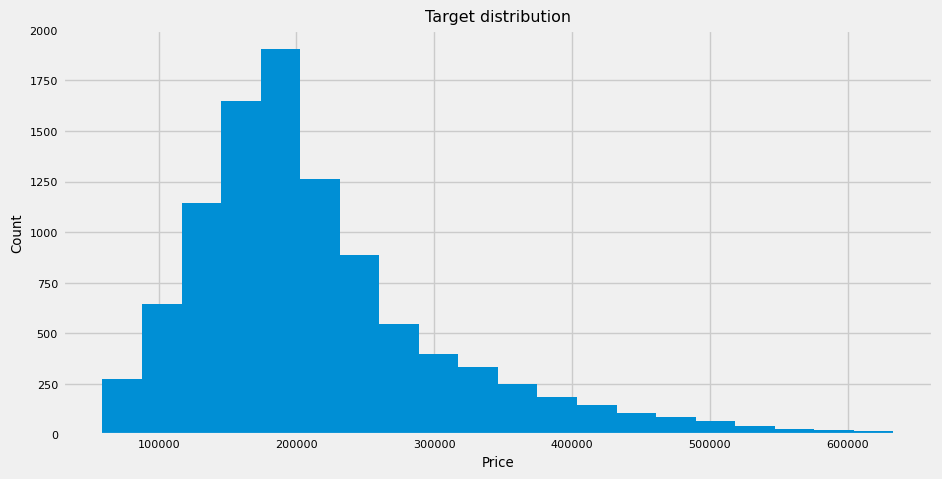

In [6]:
plt.figure(figsize=(10, 5))

plt.hist(y, bins=20)
plt.title('Target distribution')
plt.ylabel('Count')
plt.xlabel('Price')

plt.show()

### 3.2. Анализ признаков

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [9]:
print(len(X['DistrictId'].unique()))
X['DistrictId'].unique()

205


array([ 27,  22,   1,  94,  99,  44,  59,   6,   2,  88,  93,  90,  36,
        96,  48,   8,  45,  63,  20,   7, 103,  67,  24,  23,  38, 100,
        74,  35,   9, 167, 119, 129,   4,  62, 173,  37,  60, 111, 124,
       157, 138, 147,  66,  42,  41,  58,  75,  81, 110,   5,  57,  77,
        11,  61, 120, 121, 101,  32,  21, 140,  46,  91,  30,   0,  33,
        85,  17,  56,  84, 137, 143,  31,  53, 163, 200,  78, 182,  73,
        70,  98,  54,  55,   3, 159,  50,  49,  52, 127,  28,  83,  29,
       194,  47, 128,  12, 187,  80, 170,  34, 205,  79, 105, 123,  39,
       142, 176, 130,  13,  15,  25,  89, 169, 113, 108, 132, 186, 106,
        10, 139, 151, 144,  69, 189, 152, 125, 109,  40, 162,  72, 154,
        64,  26,  18, 164,  71,  82,  86, 155, 122, 112, 126, 166, 117,
       116,  95,  87,  92, 168, 136, 165, 150,  68, 191, 145,  43, 188,
       193, 146, 104,  51, 158,  97, 153, 161, 149, 107, 177, 118, 114,
       156, 160,  14,  19, 135, 148, 131, 134, 183, 185, 190, 14

In [10]:
print('Ecology_2', X['Ecology_2'].unique())
print('Ecology_3', X['Ecology_3'].unique())

Ecology_2 ['B' 'A']
Ecology_3 ['B' 'A']


In [11]:
print('Shops_2', X['Shops_2'].unique())

Shops_2 ['B' 'A']


#### Числовые признаки

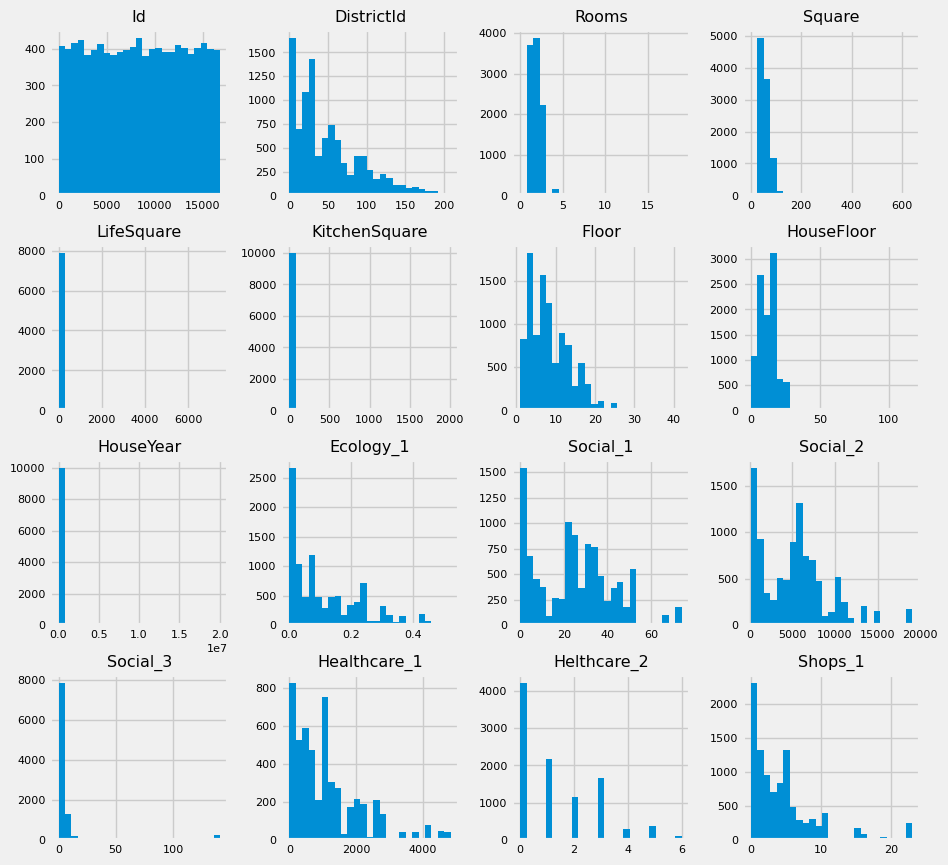

In [12]:
X[num_feat].hist(figsize=(10,10), bins=25, grid=True)
plt.show()

Есть аномальные значения в Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Social_3

#### Категориальные признаки

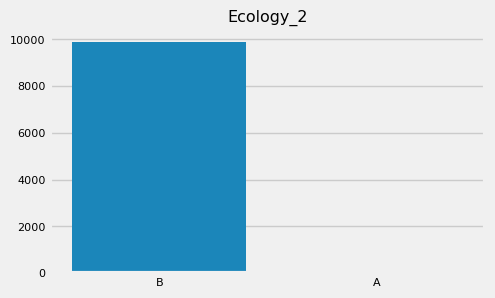

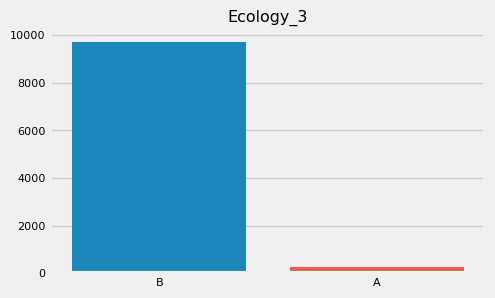

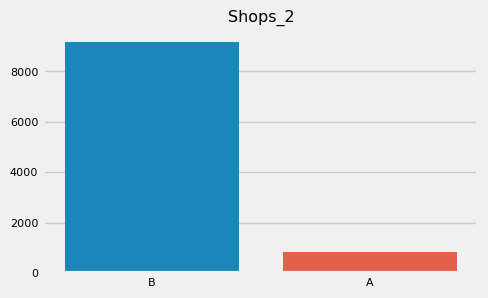

In [13]:
for feat in obj_feat:
    counts = X[feat].value_counts()
    plt.figure(figsize=(5,3))    
    plt.title(feat)
    sns.barplot(x=counts.index, y=counts.values)
    plt.show()

#### Матрица корреляций

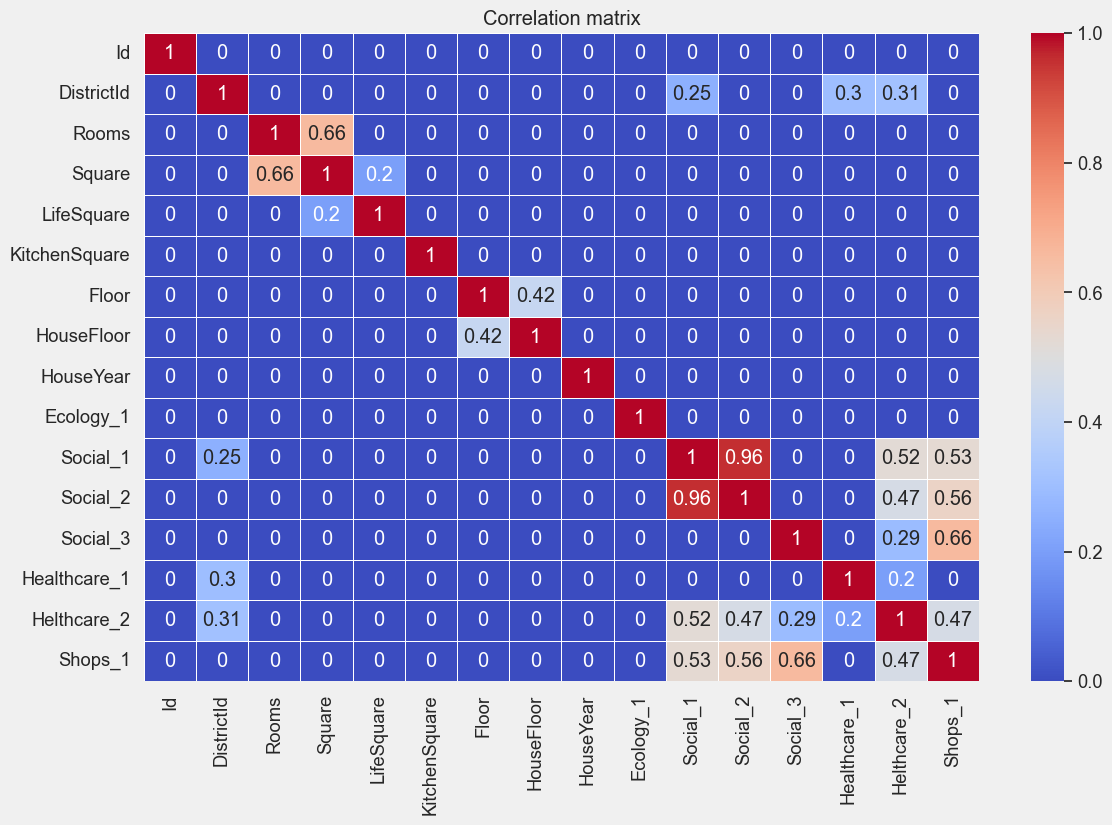

In [14]:
plt.figure(figsize = (12,8))

sns.set(font_scale=1.2)

corr_matrix = X.corr(numeric_only='silance')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Social_1 и Social_2 сильно коррелируют между собой. Нет смысла использовать 2 признака, которые описывают одно и тоже.

### 3.3. Анализ зависимости таргета от фичей

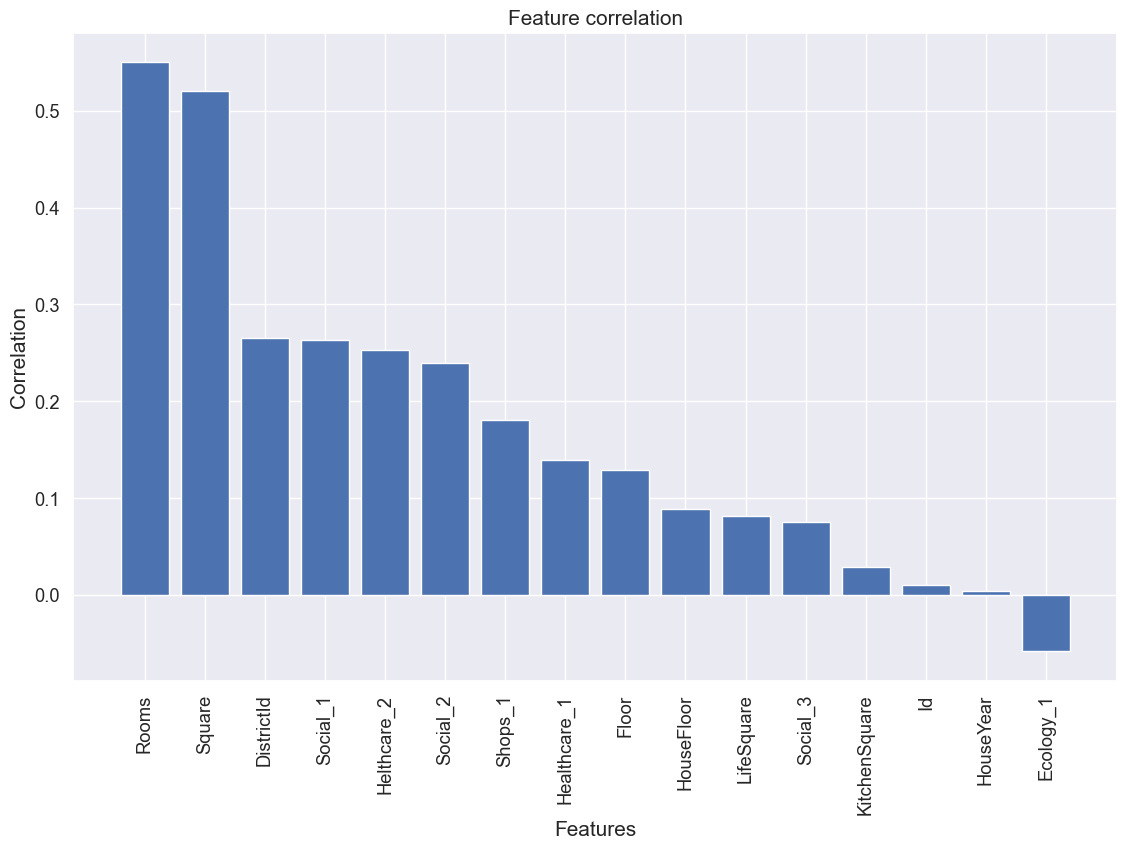

In [15]:
correlation = X.corrwith(y, numeric_only='silance').sort_values(ascending=False)

plt.figure(figsize = (12, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

Наиболее значимые признаки Rooms и Square. Как и ожидалось.
А вот HouseYear слабо коррелирует с целевой переменной, что странно. Убирать его сразу не будем. Сначала проверим правда ли он не нужен. Можно попробовать возвести в 2 и 3 степень, чтобы добавить нелинейности.

0. __Id__ - Айдишник записи. Скорее всего бесполезен (не будем использовать)
1. __DistrictId__
    1) Айдишник района. Вероятно очень полезный признак т.к. цена квартиры часто зависит от района. Нужно попробовать столкнуть с ценой и разбить на несколько категорий (205 значений многовато)

2. __Rooms__ - Кол-во комнат полезный признак.
   1) не может быть 0;
   2) Максимальное значение 19 (слишком много комнат)
   3) Явно должен быть Int а не Float

3. __Square__
    1) Похоже, что есть выбросы
4. __LifeSquare__
    1) есть пропущеные значения 
5. __KitchenSquare__

Столкнуть площади и проверить на ошибки; (LifeSquare > Square)<br>

6. __Floor__
    1) Проверить, чтобы не был больше этажности дома
7. __HouseFloor__
    1) Явно должен быть Int а не Float
8. __HouseYear__
    1) Явно должен быть Int а не Float
    2) Есть слишком большое значение - проверить
9. __Ecology_1__
    1) Похоже, что есть выбросы - проверить
10. __Ecology_2__
    1) Сделать OneHot или 0/1
11. __Ecology_3__
    1) Сделать OneHot или 0/1
12. __Social_1__
    1) Не понятно как обрабатывать. Проверить на выбросы.
13. __Social_2__
    1) Не понятно как обрабатывать. Проверить на выбросы.
14. __Social_3__
    1) Не понятно как обрабатывать. Проверить на выбросы.
15. __Healthcare_1__
    1) Много пропущеных значений, возможно для нас не пойдет
16. __Helthcare_2__
17. __Shops_1__
    1) Похоже, что есть выбросы
18. __Shops_2__
    1) Сделать OneHot или 0/1

<Axes: >

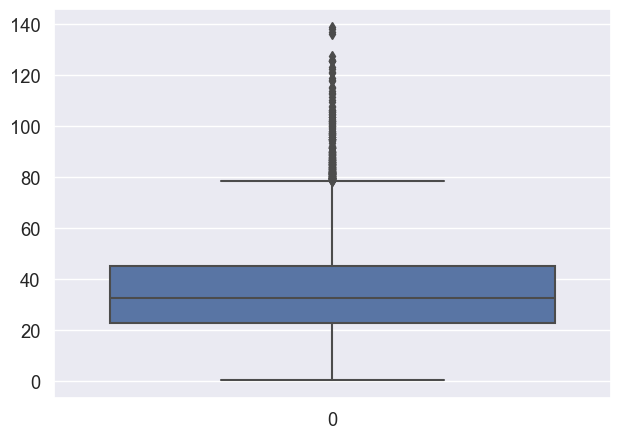

In [16]:
sns.boxplot(X.loc[(X['LifeSquare']<=150) & (~X['LifeSquare'].isna())].reset_index()['LifeSquare'])

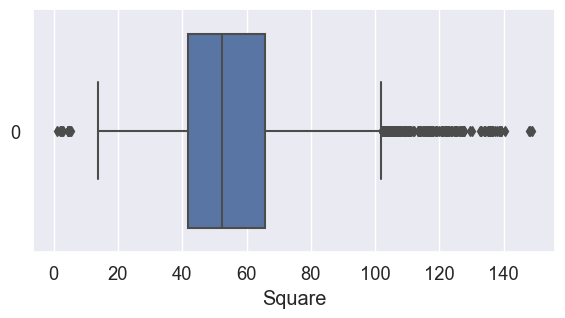

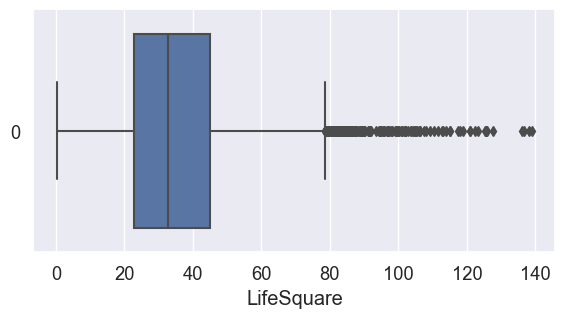

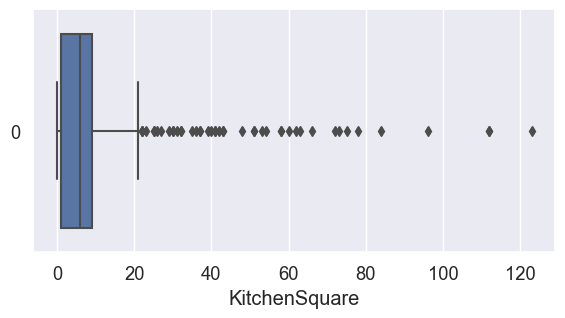

In [17]:
for col in ['Square', 'LifeSquare', 'KitchenSquare']:
    plt.figure(figsize=(6, 3))
    _filter = ((X[col]<=150) & (~X[col].isna()))
    sns.boxplot(X.loc[_filter].reset_index()[col], whis=1.5, orient='h')
    plt.xlabel(col)
    plt.show()

## 4: Очистка данных и Feature engineering

In [18]:
print('Rooms > 5:', X[X['Rooms'] > 5].size, '\nRooms <= 0:', X[X['Rooms'] <= 0].size)

Rooms > 5: 76 
Rooms <= 0: 152


#### Оборачиваем всё в единый пайплайн

In [19]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        # DistrictId
        self.distr_q = [0, 0.2, 0.4, 0.6, 0.8, 1]
        self.distr_labels = ['low', 'low_mid', 'mid', 'high_mid', 'high']

        # Rooms
        self.min_rooms = 1
        self.max_rooms = 5

        # Square
        self.min_square = 15
        self.max_square = 120

        # KitchenSquare
        # В однокомнатных квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м². (Google)
        self.min_kitchen_square = 5
        self.max_kitchen_square = 22
        
        # LifeSquare
        # Минимальная площадь общей жилой комнаты в однокомнатной квартире — 14 м². (Google)
        self.min_life_square = 14
        self.max_life_square = 78

        # Floor
        # HouseFloor
        self.min_floor = 1
        self.max_floor = 30

        # HouseYear
        self.min_year = 1900
        self.max_year = datetime.now().year
        
        pass

    def fit(self, X, y):
        """Сохранение статистик"""

        # DistrictId
        distr_price = pd.DataFrame(X['DistrictId'])
        distr_price['Price'] = y
        distr_gr = distr_price.groupby('DistrictId').agg({'Price': [np.mean,  len]})
        distr_gr.columns = distr_gr.columns.droplevel(0)

        self.mean_district_price = pd.qcut(distr_gr['mean'], q=self.distr_q, labels=self.distr_labels)
        self.district_count = pd.qcut(distr_gr['len'], q=self.distr_q, labels=self.distr_labels)

        # Square
        self.median_square = X['Square'].median()

        # LifeSquare
        other_square = (self.median_square -\
                X['LifeSquare'].median() -\
                X['KitchenSquare'].median())
        self.k_life_square = other_square / X['Square'].median()

        # Social_3
        self.median_social_3 = X['Social_3'].median()

        return self

    def transform(self, X):
        """Трансформация данных"""
        X = X.copy()
        
        # Rooms
        X.loc[X['Rooms'] < self.min_rooms, 'Rooms'] = self.min_rooms
        X.loc[X['Rooms'] > self.max_rooms, 'Rooms'] = self.max_rooms
        X['Rooms'].astype(np.int8, copy=False)
        
        # Square
        X.loc[(X['Square'] < self.min_square) |\
               (X['Square'] > self.max_square), 'Square'] = self.median_square

        # LifeSquare
        error = X['LifeSquare'].isnull()
        X.loc[error, 'LifeSquare'] = X.loc[error, 'Square'] * self.k_life_square

        X.loc[X['LifeSquare'] < self.min_life_square, 'LifeSquare'] = self.min_life_square
        X.loc[X['LifeSquare'] > self.max_life_square, 'LifeSquare'] = self.max_life_square

        # KitchenSquare
        X.loc[X['KitchenSquare'] < self.min_kitchen_square, 'KitchenSquare'] = self.min_kitchen_square
        X.loc[X['KitchenSquare'] > self.max_kitchen_square, 'KitchenSquare'] = self.max_kitchen_square

        # HouseFloor
        error = X['HouseFloor'] < self.min_floor
        X.loc[error, 'HouseFloor'] = X.loc[error, 'Floor']

        X.loc[X['HouseFloor'] > self.max_floor, 'HouseFloor'] = self.max_floor

        error = X['Floor'] > X['HouseFloor']
        X.loc[error, 'Floor'] = X.loc[error, 'HouseFloor']

        # HouseYear
        X.loc[X['HouseYear'] < self.min_year, 'HouseYear'] = self.min_year
        X.loc[X['HouseYear'] > self.max_year, 'HouseYear'] = self.max_year

        # Бинарные признаки
        X['Ecology_2b'] = X['Ecology_2'].replace({'A':1, 'B':2})
        X['Ecology_3b'] = X['Ecology_3'].replace({'A':10, 'B':20})
        X['Shops_b'] = X['Shops_2'].replace({'A':0, 'B':1})
        
        X = self.features(X) # Сгенерируем новые признаки
        # Уберём лишнее
        X = X.drop(['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Healthcare_1'], axis=1)
        
        # Добавим нелинейности
        for col in X.columns:
            if X[col].unique().size <= 2:
                continue

            for i in range(2, 4):
                X[col+f'_{i}'] = X[col] ** i

        return X

    def features(self, X):
        """Построение новых признаков"""

        X = X.merge(self.mean_district_price, on="DistrictId", how="left")
        X = X.merge(self.district_count, on="DistrictId", how="left")
        X.loc[X['mean'].isna(), 'mean'] = 'mid'
        X.loc[X['len'].isna(), 'len'] = 'mid'

        X = X.join(pd.get_dummies(X['mean'], prefix='mean'))
        X = X.join(pd.get_dummies(X['len'], prefix='len'))
        X = X.drop(['mean','len'], axis=1)
                
        return X

In [20]:
pipeline = DataPipeline()
pipeline.fit(X, y)
pipeline.transform(X).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            10000 non-null  float64
 1   Square           10000 non-null  float64
 2   LifeSquare       10000 non-null  float64
 3   KitchenSquare    10000 non-null  float64
 4   Floor            10000 non-null  int64  
 5   HouseFloor       10000 non-null  float64
 6   HouseYear        10000 non-null  int64  
 7   Ecology_1        10000 non-null  float64
 8   Social_1         10000 non-null  int64  
 9   Social_2         10000 non-null  int64  
 10  Social_3         10000 non-null  int64  
 11  Helthcare_2      10000 non-null  int64  
 12  Shops_1          10000 non-null  int64  
 13  Ecology_2b       10000 non-null  int64  
 14  Ecology_3b       10000 non-null  int64  
 15  Shops_b          10000 non-null  int64  
 16  mean_low         10000 non-null  uint8  
 17  mean_low_mid 

In [21]:
pipeline.transform(X)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Social_1_2,Social_1_3,Social_2_2,Social_2_3,Social_3_2,Social_3_3,Helthcare_2_2,Helthcare_2_3,Shops_1_2,Shops_1_3
0,3.0,115.027311,30.079246,10.0,4,10.0,2014,0.075424,11,3097,...,121,1331,9591409,29704593673,0,0,0,0,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,...,900,27000,38526849,239136151743,1,1,1,1,0,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,...,1089,35937,27678121,145614594581,0,0,9,27,1,1
3,1.0,40.409907,14.000000,5.0,10,22.0,1977,0.007122,1,264,...,1,1,69696,18399744,0,0,0,0,1,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,...,1089,35937,75116889,651038076963,4,8,0,0,36,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,...,2704,140608,106316721,1096231710231,36,216,1,1,81,729
9996,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,2,629,...,4,8,395641,248858189,1,1,0,0,0,0
9997,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,...,400,8000,19236996,84373464456,196,2744,1,1,25,125
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,...,2209,103823,64064016,512768384064,9,27,9,27,25,125


## 5. Разбиение на train / test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4349,6548,161,1.0,33.901173,19.146710,6.0,4,8.0,1963,0.000699,B,B,14,3369,24,4129.0,0,3,B
3754,7566,6,2.0,60.829736,35.632118,10.0,12,25.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
4474,4939,122,3.0,75.222209,46.157077,10.0,10,14.0,1996,0.033494,B,B,66,10573,1,1322.0,3,8,B
1028,4311,30,2.0,63.082678,NaN,1.0,25,25.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,7166,66,2.0,44.346316,30.833605,5.0,6,5.0,1961,0.111627,B,B,50,12238,8,1970.0,2,3,B
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B
7233,16213,70,3.0,69.476785,46.574630,9.0,9,14.0,1977,0.002212,B,B,39,7614,3,NaN,1,5,A
423,3007,13,1.0,39.487218,21.034795,7.0,12,17.0,2004,0.090799,B,B,74,19083,2,NaN,5,15,B


## 6. Построение модели

In [23]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(16,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [24]:
pipeline = DataPipeline()
pipeline.fit(X_train, y_train)

Train R2:	0.67
Test R2:	0.659


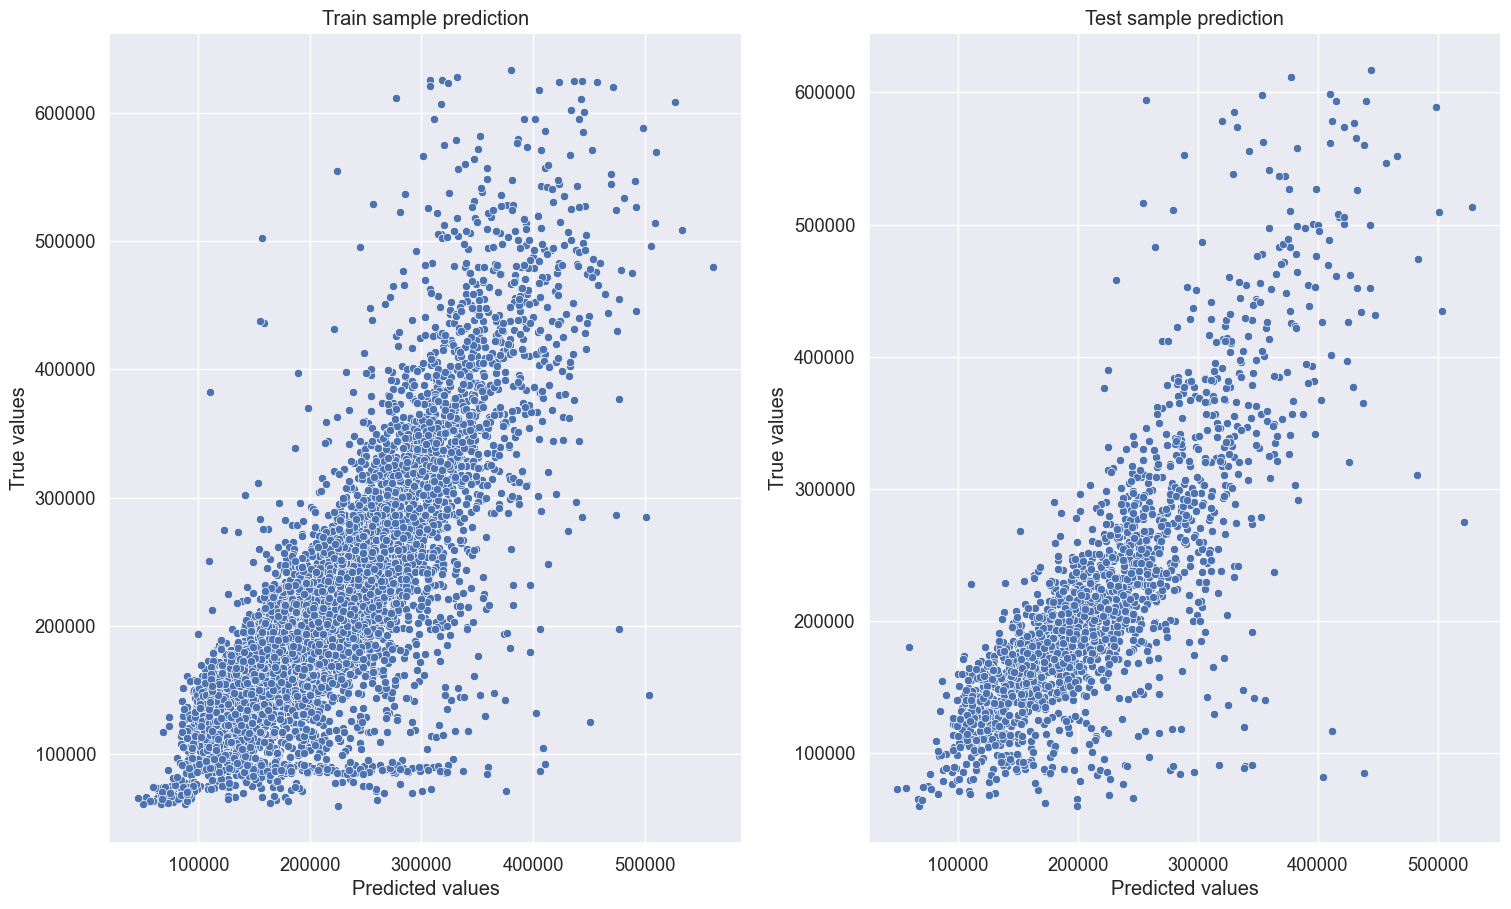

In [25]:
X_train_tr = pipeline.transform(X_train)
X_test_tr = pipeline.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_tr)

lr = LinearRegression()
lr.fit(scaler.transform(X_train_tr), y_train)

train_pred = lr.predict(scaler.transform(X_train_tr))
test_pred = lr.predict(scaler.transform(X_test_tr))

evaluate_preds(y_train, train_pred, y_test, test_pred)

Train R2:	0.959
Test R2:	0.573


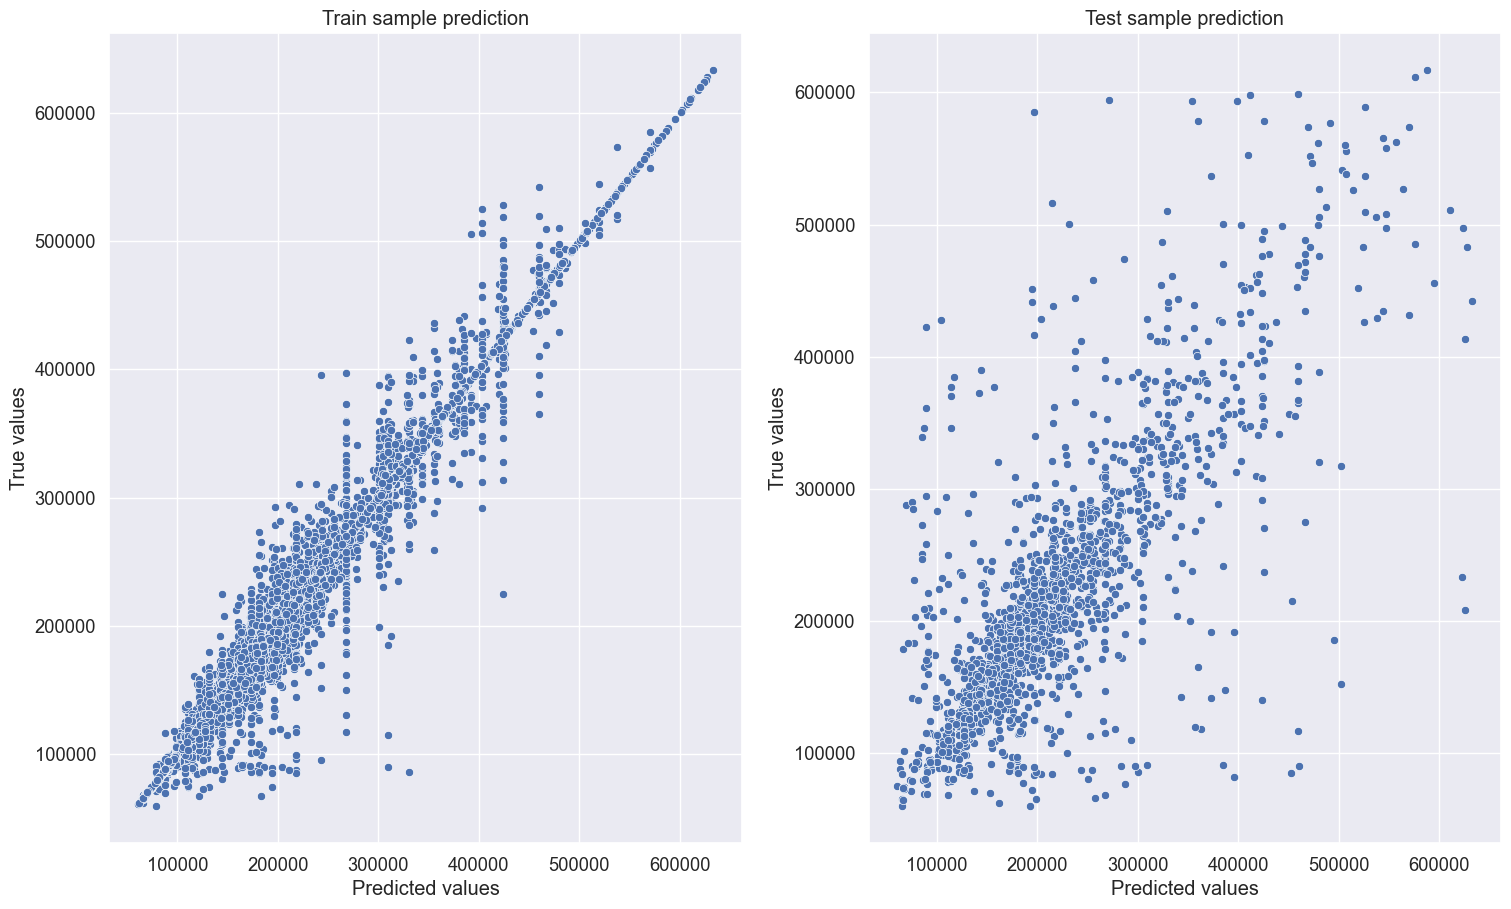

In [26]:
model = DecisionTreeRegressor(max_depth=15)
model.fit(pipeline.transform(X_train), y_train)

train_pred = model.predict(pipeline.transform(X_train))
test_pred = model.predict(pipeline.transform(X_test))

evaluate_preds(y_train, train_pred, y_test, test_pred)

Train R2:	0.963
Test R2:	0.75


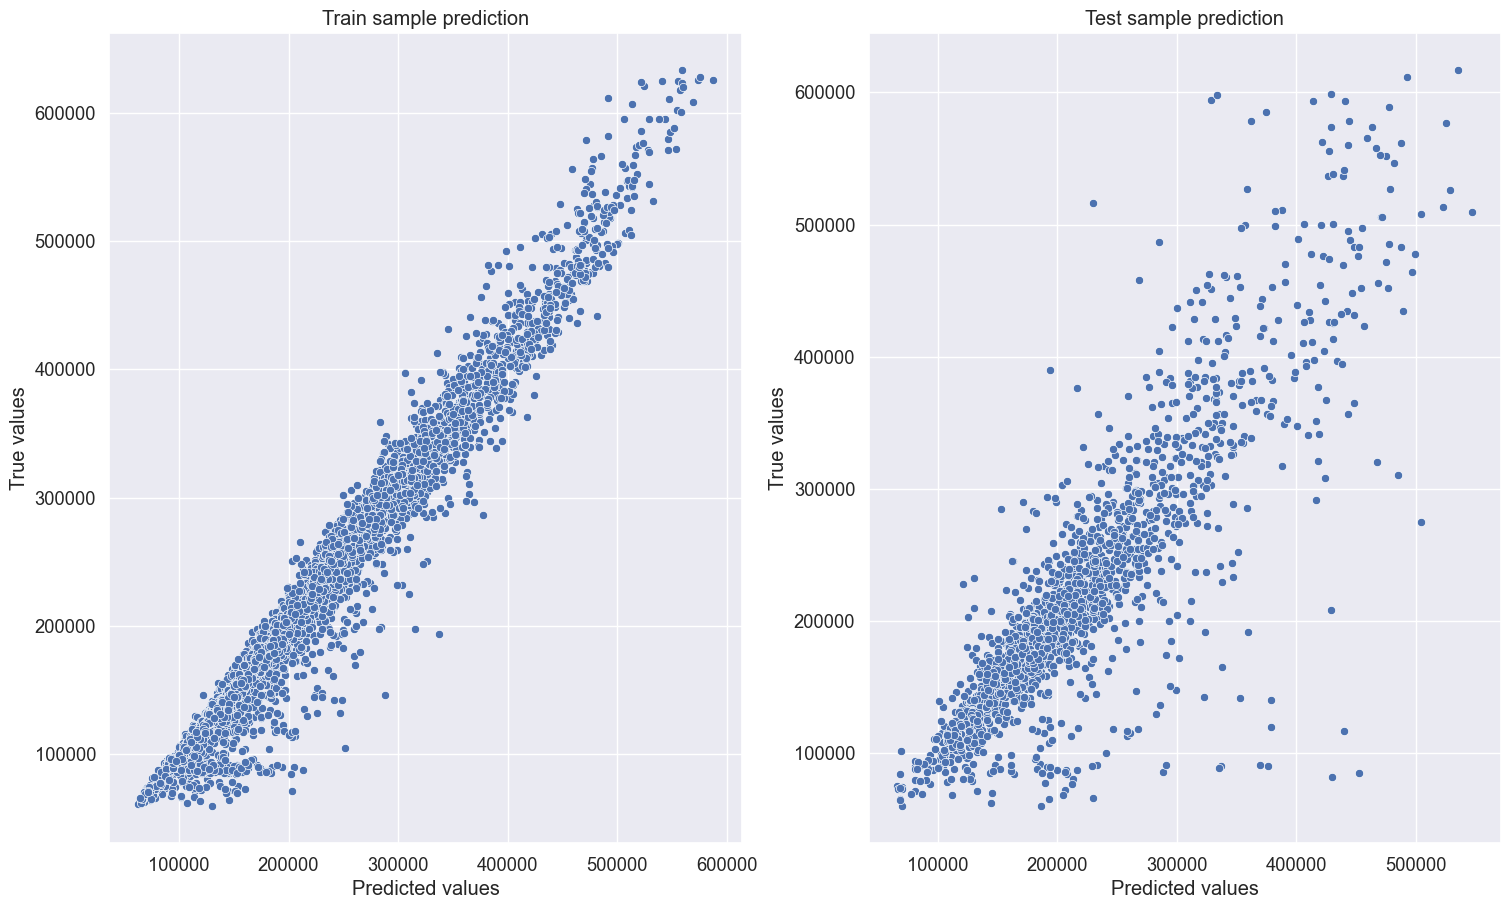

In [27]:
model = RandomForestRegressor()
model.fit(pipeline.transform(X_train), y_train)

train_pred = model.predict(pipeline.transform(X_train))
test_pred = model.predict(pipeline.transform(X_test))

evaluate_preds(y_train, train_pred, y_test, test_pred)

In [28]:
feature_importances = pd.DataFrame(
    zip(pipeline.transform(X_train).columns, model.feature_importances_), 
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False).head(7)

,feature_name,importance
16,mean_low,0.206682
28,Square_2,0.121779
29,Square_3,0.117465
1,Square,0.104881
27,Rooms_3,0.043382
26,Rooms_2,0.039632
0,Rooms,0.025513


Train R2:	0.962
Test R2:	0.732


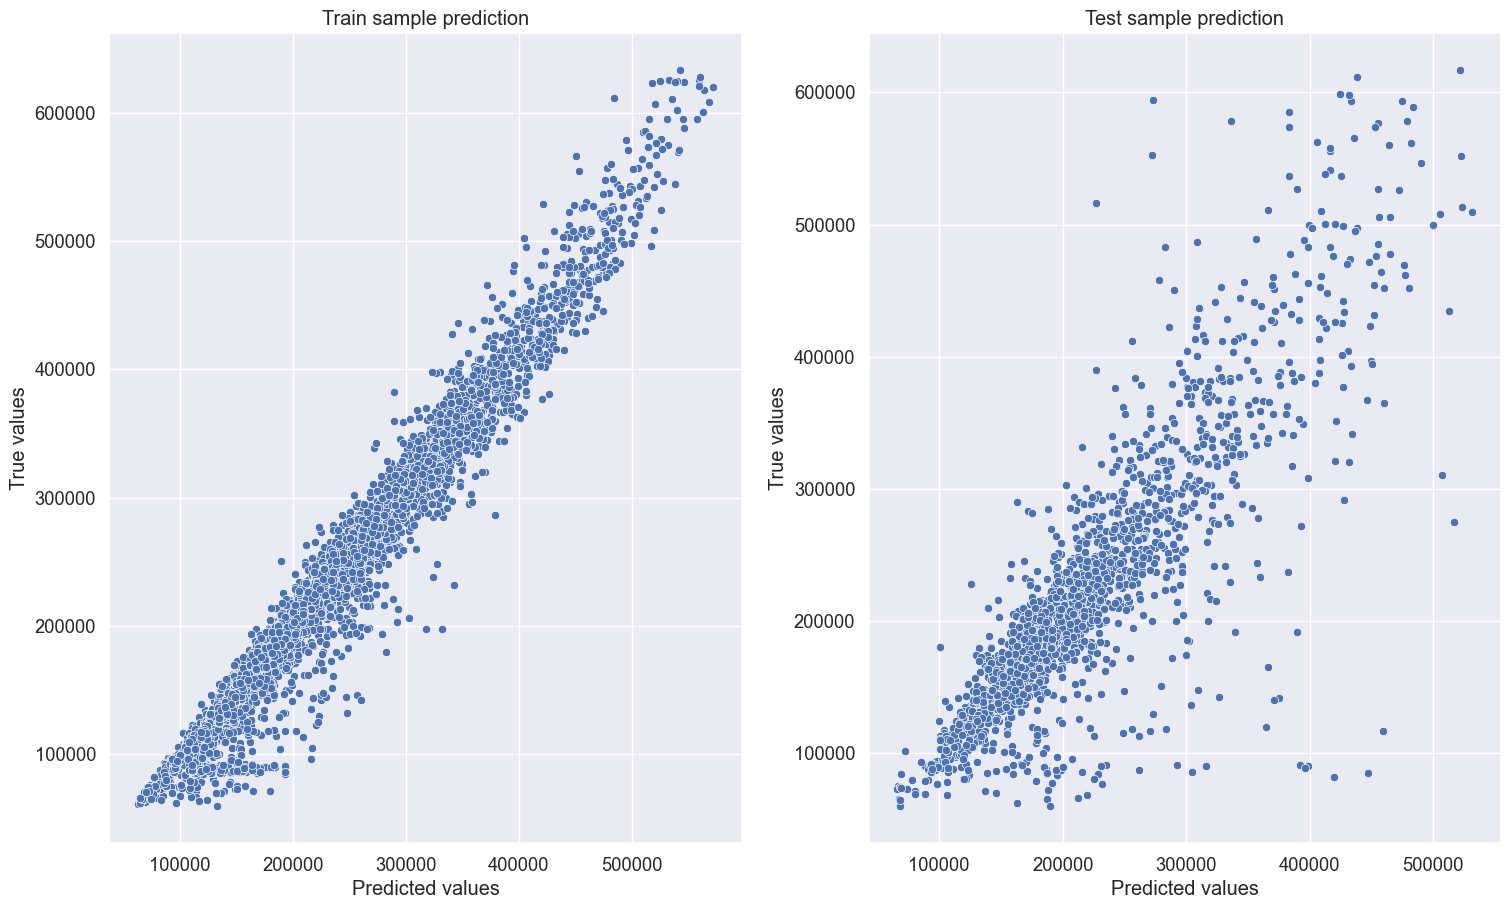

In [29]:
X_train_tr = pipeline.transform(X_train)
X_test_tr = pipeline.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_tr)

lr = LinearRegression()
lr.fit(scaler.transform(X_train_tr), y_train)

X_train_tr['lr_pred'] = lr.predict(scaler.transform(X_train_tr))
X_test_tr['lr_pred'] = lr.predict(scaler.transform(X_test_tr))

model = RandomForestRegressor()
model.fit(X_train_tr, y_train)

train_pred = model.predict(X_train_tr)
test_pred = model.predict(X_test_tr)

evaluate_preds(y_train, train_pred, y_test, test_pred)

In [30]:
feature_importances = pd.DataFrame(
    zip(X_train_tr.columns, model.feature_importances_), 
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False).head(7)

,feature_name,importance
52,lr_pred,0.714219
1,Square,0.015285
28,Square_2,0.014782
29,Square_3,0.014676
31,LifeSquare_3,0.011522
2,LifeSquare,0.010937
30,LifeSquare_2,0.010389


In [42]:
parameters = [{'n_estimators': [40, 50, 70, 100, 130, 150, 170, 200],
               'max_features': np.arange(5, 10),
               'max_depth': np.arange(10, 15)}]

cv = GridSearchCV(estimator=RandomForestRegressor(random_state=RANDOM_STATE),
                  param_grid=parameters,
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)

In [43]:
%%time

pipeline = DataPipeline()
pipeline.fit(X_train, y_train)

X_train_tr = pipeline.transform(X_train)
result = cv.fit(X_train_tr, y_train)

CPU times: total: 12 s
Wall time: 50.3 s


In [44]:
result.best_params_

{'max_depth': 14, 'max_features': 8, 'n_estimators': 150}

## 7. Оценка финальной модели

Train R2:	0.928
Test R2:	0.755


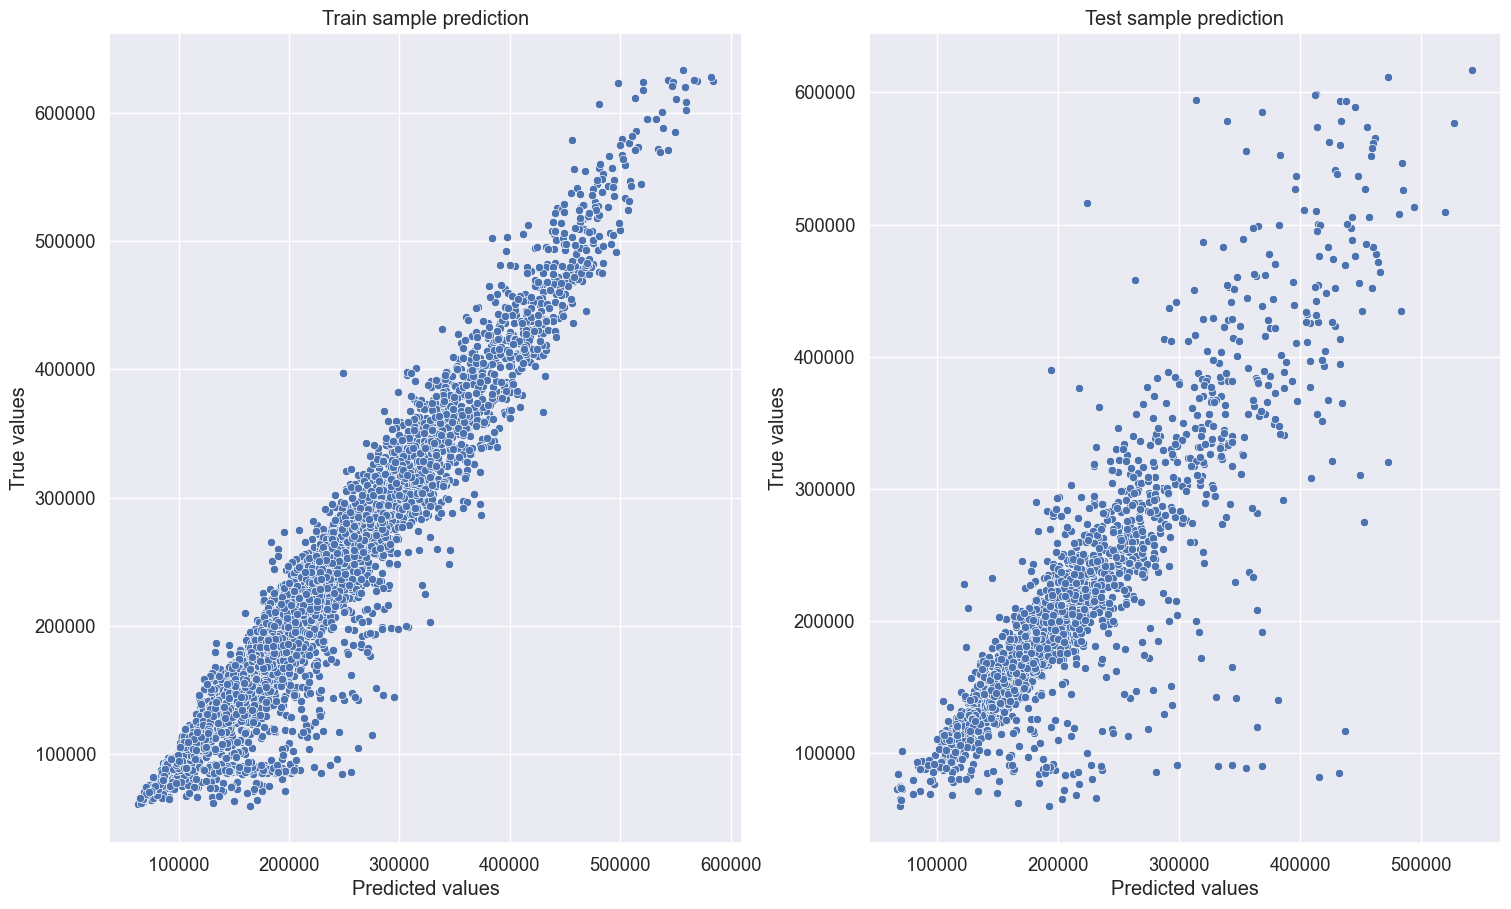

In [45]:
pipeline = DataPipeline()
pipeline.fit(X_train, y_train)

model = RandomForestRegressor(max_depth=14, max_features=8, n_estimators=150)
model.fit(pipeline.transform(X_train), y_train)

train_pred = model.predict(pipeline.transform(X_train))
test_pred = model.predict(pipeline.transform(X_test))

evaluate_preds(y_train, train_pred, y_test, test_pred)

## 8. Прогнозирование на тестовом датасете

In [46]:
pipeline = DataPipeline()
pipeline.fit(X, y)

model = RandomForestRegressor(max_depth=14, max_features=8, n_estimators=150)
model.fit(pipeline.transform(X), y)

RandomForestRegressor(max_depth=14, max_features=8, n_estimators=150)

In [50]:
test_X = pd.read_csv(DATA_PATH / 'test.csv')
cols = data.columns

test_X.sample(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
898,172,6,2.0,63.537022,NaN,1.0,9,25.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
1581,3464,49,2.0,46.608239,30.255431,5.0,1,5.0,1962,0.020741,B,B,24,5613,5,1340.0,2,5,B
4555,4485,13,1.0,39.185109,20.403370,8.0,11,16.0,2002,0.133215,B,B,49,11395,3,1406.0,3,4,A
2539,10766,67,2.0,65.386024,47.038509,14.0,11,12.0,1977,0.007720,B,B,38,4788,2,NaN,0,4,B


In [51]:
submission = pd.DataFrame()
submission['Id'] = test_X['Id']
submission['Price'] = model.predict(pipeline.transform(test_X))
submission.head()

,Id,Price
0,4567,160191.718457
1,5925,124536.686174
2,960,142764.024624
3,3848,135884.820683
4,746,188187.260281


In [52]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.3 KB


In [53]:
submission.to_csv('submission.csv', index=False)

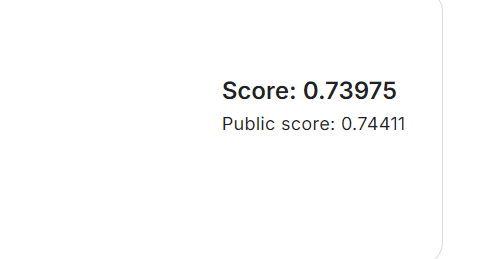